In [3]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import AerSimulator
from qiskit_mps_initializer.datatypes import QuantumState
from qiskit.quantum_info import partial_trace, DensityMatrix, state_fidelity
import numpy as np
import matplotlib.pyplot as plt

#psi and phi
psi = [1, 2, 3, 4, 5, 6, 7, 8]
phi = [1, 1, 1, 1, 1, 1, 1, 1]

n = 3
number_of_layers = 2

#create normalized QuantumState objects
psi_state = QuantumState.from_dense_data(data=psi, normalize=True)
phi_state = QuantumState.from_dense_data(data=phi, normalize=True)

#generate MPS initializer circuits
U_psi = psi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi = phi_state.generate_mps_initializer_circuit(number_of_layers=number_of_layers)
U_phi_dagger = U_phi.inverse()



def build_protocol(delta, m):
    psi_reg = QuantumRegister(n, "ψ")
    phi_reg = QuantumRegister(n, "φ")
    creg = ClassicalRegister(n, "c")
    qc = QuantumCircuit(psi_reg, phi_reg, creg)

    qc.append(U_psi, psi_reg)
    qc.append(U_phi, phi_reg)

    for _ in range(m):
        # CNOT flag steps
        for i in range(n):
            qc.cx(phi_reg[n-1-i], psi_reg[n-1-i], ctrl_state=0)

        # small phase
        qc.mcp(delta, psi_reg[:-1], psi_reg[-1])

        # uncompute flags
        for i in range(n):
            qc.cx(phi_reg[i], psi_reg[i], ctrl_state=0)

        # uncompute phi, measure and reset
        qc.append(U_phi_dagger, phi_reg)
        qc.measure(phi_reg, creg)
        qc.reset(phi_reg)

        # reinitialize φ 
        qc.append(U_phi, phi_reg)

    return qc



def run_fidelity(delta, m):
    qc = build_protocol(delta, m)
    sim = AerSimulator(method="statevector")
    qc.save_statevector()
    result = sim.run(transpile(qc, sim)).result()
    full_state = result.get_statevector(qc)

    # partial trace to get ψ subsystem
    rho_psi = partial_trace(full_state, list(range(n, 2*n)))

    # ideal state
    psi_vec = np.array(psi) / np.linalg.norm(psi)
    phi_vec = np.array(phi) / np.linalg.norm(phi)
    phase_profile = np.exp(1j * delta * m * np.abs(phi_vec)**2)
    ideal_vec = psi_vec * phase_profile
    rho_ideal = DensityMatrix(ideal_vec)

    return state_fidelity(rho_psi, rho_ideal), qc



def run_shots(delta, m, shots=1000):
    qc = build_protocol(delta, m)
    sim = AerSimulator()
    tqc = transpile(qc, sim)
    result = sim.run(tqc, shots=shots).result()
    counts = result.get_counts(qc)
    return counts, qc







memories ['000', '000', '000', '000', '000']
δ = 0.00785, m = 2, shots = 5
Successful shots (ancilla = 000): 5/5
Success rate = 1.000


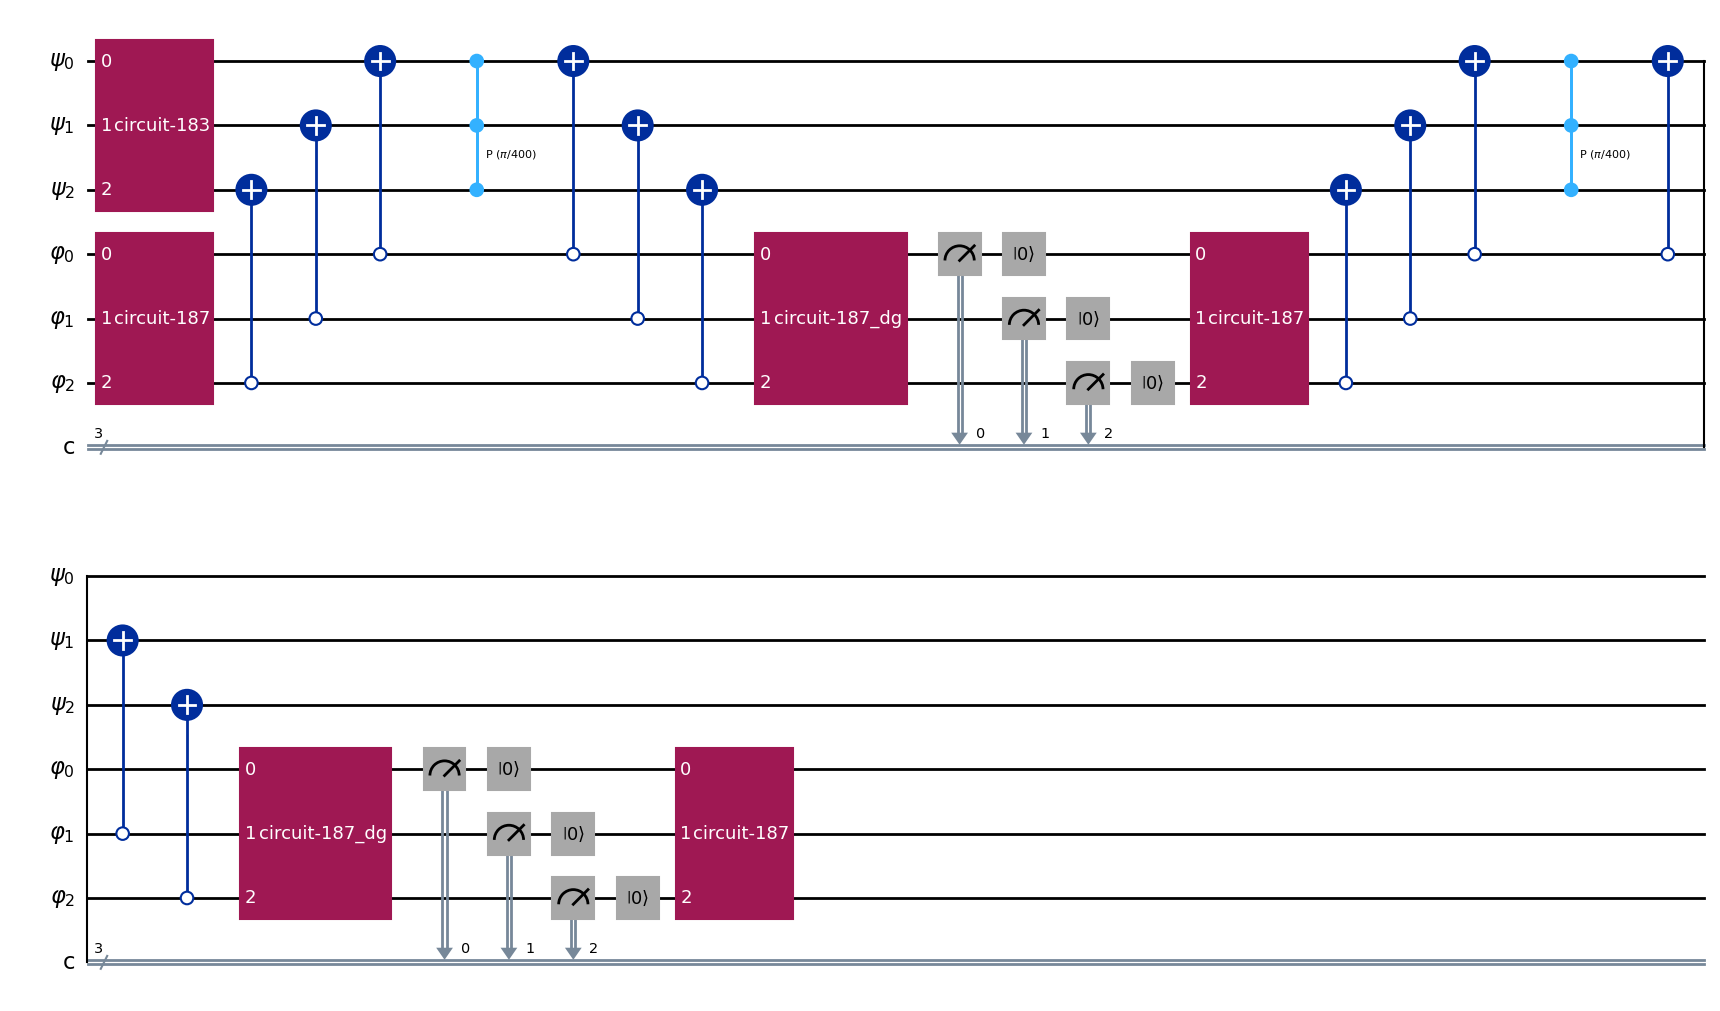

In [18]:
def success_rate(delta, m=1, shots=1000):
    qc = build_protocol(delta, m)
    sim = AerSimulator()
    tqc = transpile(qc, sim)

    # run with memory output for individual shots
    result = sim.run(tqc, shots=shots, memory=True).result()
    memories = result.get_memory(qc)     # list of measured bitstrings

    # count how many are all zeros
    zero_state = "0" * n
    successes = sum(1 for s in memories if s == zero_state)
    success_fraction = successes / shots
    print('memories', memories)
    print(f"δ = {delta:.5f}, m = {m}, shots = {shots}")
    print(f"Successful shots (ancilla = {zero_state}): {successes}/{shots}")
    print(f"Success rate = {success_fraction:.3f}")

    return success_fraction, memories, qc

    
# Example usage
delta = np.pi / 400
success_fraction, all_shots, qc = success_rate(delta, m=2, shots=5)
qc.draw("mpl")


δ = 0.78540, m = 1, shots = 2000
Successful shots (ancilla = 000): 1878/2000
Success rate = 0.939
δ = 0.07854, m = 1, shots = 2000
Successful shots (ancilla = 000): 2000/2000
Success rate = 1.000
δ = 0.00785, m = 1, shots = 2000
Successful shots (ancilla = 000): 2000/2000
Success rate = 1.000
δ = 0.00079, m = 1, shots = 2000
Successful shots (ancilla = 000): 2000/2000
Success rate = 1.000


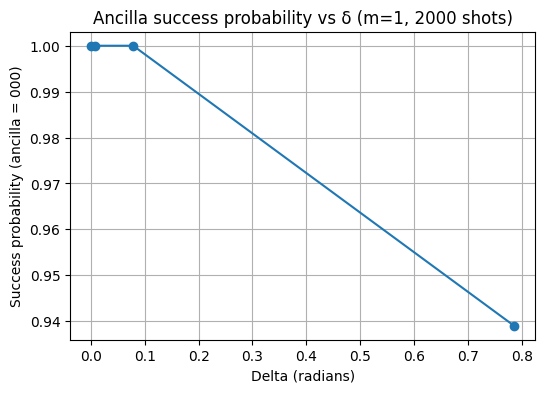

In [5]:
delta_values = [np.pi/4, np.pi/40, np.pi/400, np.pi/4000]
rates = [success_rate(d, m=1, shots=2000)[0] for d in delta_values]

plt.figure(figsize=(6,4))
plt.plot(delta_values, rates, 'o-')
plt.xlabel("Delta (radians)")
plt.ylabel("Success probability (ancilla = 000)")
plt.title("Ancilla success probability vs δ (m=1, 2000 shots)")
plt.grid(True)
plt.show()


δ = 0.78540, m = 1, shots = 200
Successful shots (ancilla = 000): 189/200
Success rate = 0.945
δ = 0.78540, m = 2, shots = 200
Successful shots (ancilla = 000): 189/200
Success rate = 0.945
δ = 0.78540, m = 3, shots = 200
Successful shots (ancilla = 000): 181/200
Success rate = 0.905
δ = 0.78540, m = 4, shots = 200
Successful shots (ancilla = 000): 193/200
Success rate = 0.965
δ = 0.78540, m = 5, shots = 200
Successful shots (ancilla = 000): 179/200
Success rate = 0.895
δ = 0.78540, m = 6, shots = 200
Successful shots (ancilla = 000): 193/200
Success rate = 0.965
δ = 0.78540, m = 7, shots = 200
Successful shots (ancilla = 000): 191/200
Success rate = 0.955
δ = 0.78540, m = 8, shots = 200
Successful shots (ancilla = 000): 184/200
Success rate = 0.920
δ = 0.78540, m = 9, shots = 200
Successful shots (ancilla = 000): 193/200
Success rate = 0.965
δ = 0.78540, m = 10, shots = 200
Successful shots (ancilla = 000): 190/200
Success rate = 0.950
δ = 0.78540, m = 11, shots = 200
Successful shots

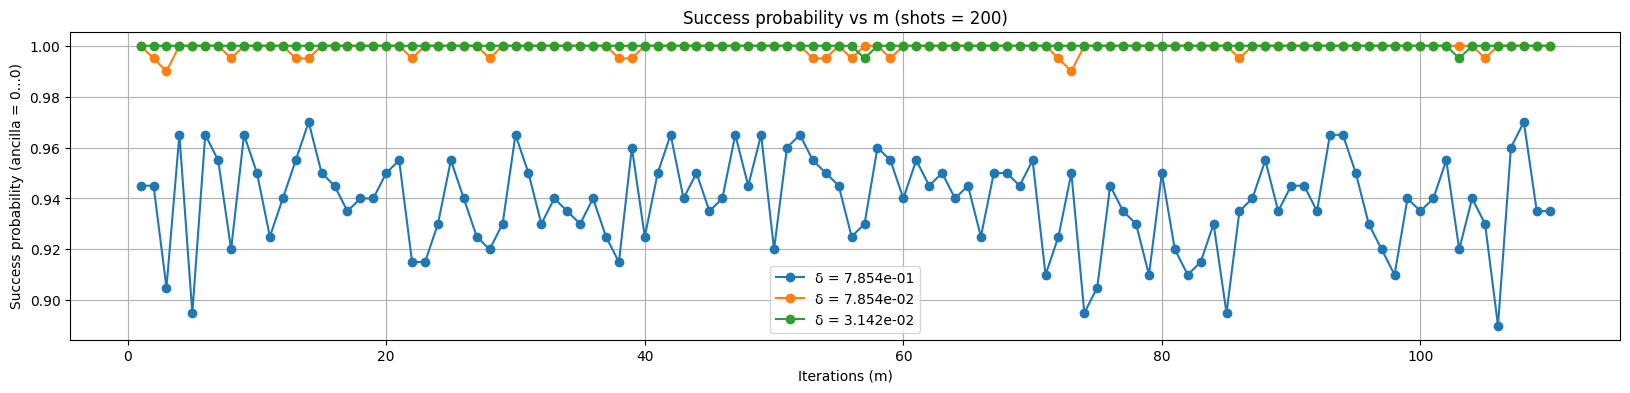

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# --- sweep over multiple δ values, same plot ---
def compare_deltas(delta_values, m_values, shots=200):
    """
    For each delta in delta_values, run success_rate(delta, m, shots)
    for all m in m_values and plot all curves together.
    """
    plt.figure(figsize=(20,4))
    for delta in delta_values:
        rates = [success_rate(delta, m, shots=shots)[0] for m in m_values]
        plt.plot(m_values, rates, 'o-', label=f"δ = {delta:.3e}")
    plt.xlabel("Iterations (m)")
    plt.ylabel("Success probability (ancilla = 0...0)")
    plt.title(f"Success probability vs m (shots = {shots})")
    plt.grid(True)
    plt.legend()
    plt.show()

# === Example usage ===
delta_values = [np.pi/4, np.pi/40, np.pi/100]   # list of δ values
m_values = list(range(1, 111))                   # m = 1 → 10

compare_deltas(delta_values, m_values, shots=200)


In [7]:
def compare_deltas(delta_values, m_values, shots=200):
    all_data = []   # collect (delta, m, success)
    plt.figure(figsize=(10,4))

    for delta in delta_values:
        rates = []
        for m in m_values:
            p = success_rate(delta, m, shots=shots)
            # success_rate might return (probability, memory, qc)
            if isinstance(p, tuple):
                p = p[0]
            rates.append(p)
            all_data.append((delta, m, p))

        # plot one curve per delta
        plt.plot(m_values, rates, 'o-', label=f"δ = {delta:.3e}")

    # finalize the plot
    plt.xlabel("Iterations (m)")
    plt.ylabel("Success probability (ancilla = 0...0)")
    plt.title(f"Success probability vs m (shots = {shots})")
    plt.grid(True)
    plt.legend()
    plt.show()

    return all_data


δ = 0.78540, m = 1, shots = 20
Successful shots (ancilla = 000): 19/20
Success rate = 0.950
δ = 0.78540, m = 2, shots = 20
Successful shots (ancilla = 000): 18/20
Success rate = 0.900
δ = 0.78540, m = 3, shots = 20
Successful shots (ancilla = 000): 19/20
Success rate = 0.950
δ = 0.78540, m = 4, shots = 20
Successful shots (ancilla = 000): 20/20
Success rate = 1.000
δ = 0.78540, m = 5, shots = 20
Successful shots (ancilla = 000): 17/20
Success rate = 0.850
δ = 0.07854, m = 1, shots = 20
Successful shots (ancilla = 000): 20/20
Success rate = 1.000
δ = 0.07854, m = 2, shots = 20
Successful shots (ancilla = 000): 20/20
Success rate = 1.000
δ = 0.07854, m = 3, shots = 20
Successful shots (ancilla = 000): 20/20
Success rate = 1.000
δ = 0.07854, m = 4, shots = 20
Successful shots (ancilla = 000): 20/20
Success rate = 1.000
δ = 0.07854, m = 5, shots = 20
Successful shots (ancilla = 000): 20/20
Success rate = 1.000
δ = 0.03142, m = 1, shots = 20
Successful shots (ancilla = 000): 20/20
Success r

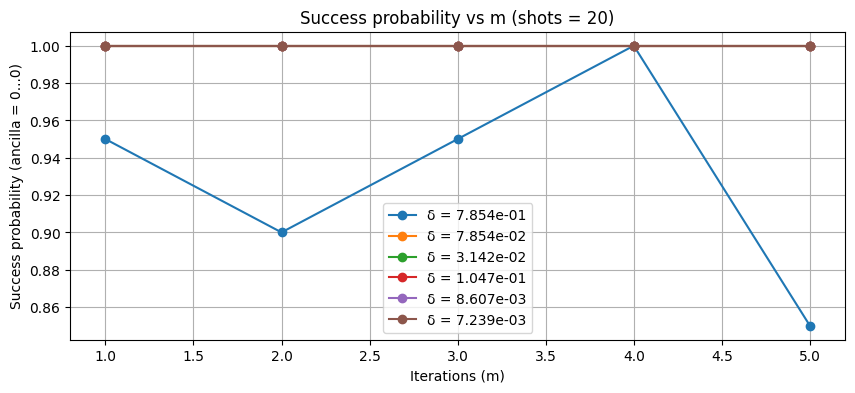

In [8]:
delta_values = [np.pi/4, np.pi/40, np.pi/100, np.pi/30, np.pi/365, np.pi/434]
m_values = list(range(1, 6))   # try 1–5 to test; later you can extend to 1–110

data = compare_deltas(delta_values, m_values, shots=20)


In [9]:
import pandas as pd
df = pd.DataFrame(data, columns=["delta", "m", "success"])
print(df)


       delta  m  success
0   0.785398  1     0.95
1   0.785398  2     0.90
2   0.785398  3     0.95
3   0.785398  4     1.00
4   0.785398  5     0.85
5   0.078540  1     1.00
6   0.078540  2     1.00
7   0.078540  3     1.00
8   0.078540  4     1.00
9   0.078540  5     1.00
10  0.031416  1     1.00
11  0.031416  2     1.00
12  0.031416  3     1.00
13  0.031416  4     1.00
14  0.031416  5     1.00
15  0.104720  1     1.00
16  0.104720  2     1.00
17  0.104720  3     1.00
18  0.104720  4     1.00
19  0.104720  5     1.00
20  0.008607  1     1.00
21  0.008607  2     1.00
22  0.008607  3     1.00
23  0.008607  4     1.00
24  0.008607  5     1.00
25  0.007239  1     1.00
26  0.007239  2     1.00
27  0.007239  3     1.00
28  0.007239  4     1.00
29  0.007239  5     1.00
